Dengue is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash and muscle and joint pain. But severe cases are dangerous, and dengue fever can cause severe bleeding, low blood pressure and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

This competition is on (https://www.drivendata.org/competitions/44/) to use open data to predict the occurrence of Dengue based on climatological data.

As always, we begin with the sacred `import`'s of data science:

In [5]:
%matplotlib inline

#from __future__ import print_function
#from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold

## A Tale of Two Cities

![](https://community.drivendata.org/uploads/default/original/1X/4c3a8204d1715b5e2ee24da78abbad1515eccd5f.png)

This dataset has two cities in it: San Juan, Puerto Rico (right) and Iquitos, Peru (left). Since we hypothesize that the spread of dengue may follow different patterns between the two, we will divide the dataset, train seperate models for each city, and then join our predictions before making our final submission.

In [6]:
# load the provided data
train_features = pd.read_csv('/Users/eroolpal/Downloads/dengue_features_train.csv')

train_labels = pd.read_csv('/Users/eroolpal/Downloads/dengue_labels_train.csv')
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [7]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [8]:
#print(train_features.weekofyear)

The [problem description](https://www.drivendata.org/competitions/44/page/82/) gives a good overview of the available variables, but we'll look at the head of the data here as well:

Next, let's check to see if we are missing any values in this dataset:

In [9]:
# Null check
pd.isnull(train_features).any()

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_t

Text(0.5, 0, 'Time')

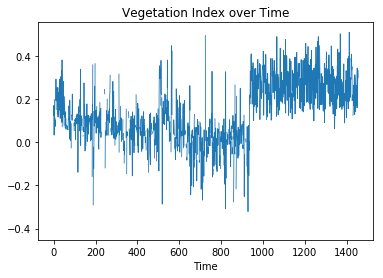

In [10]:
(train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

Since these are time-series, we can see the gaps where there are `NaN`s by plotting the data. Since we can't build a model without those values, we'll take a simple approach and just fill those values with the most recent value that we saw up to that point. This is probably a good part of the problem to improve your score by getting smarter.

 # separate the Categorical values and numerical values

In [11]:

cat_val = train_features.select_dtypes(include=['object']).copy()
cat_val.drop('week_start_date', axis=1, inplace=True)
num_val = train_features.drop(cat_val,axis=1)
num_val.fillna(method='ffill', inplace=True)
#sj_train_features.fillna(sj_train_features.mean(), inplace=True)
#iq_train_features.fillna(iq_train_features.mean(), inplace=True)

## Distribution of labels

Our target variable, `total_cases` is a non-negative integer, which means we're looking to make some **count predictions**. Standard regression techniques for this type of prediction include

1. Poisson regression
2. Negative binomial regression

Initially the negative binomial regression was used, but here we use otheer machine learning techniques.

In [12]:
print('total')
print('mean: ', num_val.mean()[2])
print('var :', num_val.var()[2])



total
mean:  0.13127138796703314
var : 0.019189678045667725


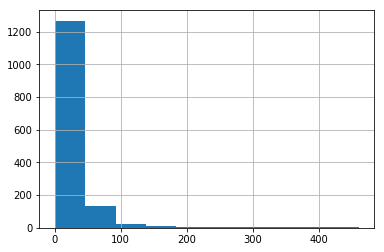

In [13]:
train_labels.total_cases.hist()

### `variance  >>  mean` suggests `total_cases` can be described by a negative binomial distribution, so we'll use a negative binomial regression below.

## Which inputs strongly correlate with `total_cases`?

Our next step in this process will be to select a subset of features to include in our regression. Our primary purpose here is to get a better understanding of the problem domain rather than eke out the last possible bit of predictive accuracy. The first thing we will do is to add the `total_cases` to our dataframe, and then look at the correlation of that variable with the climate variables.

In [14]:
num_val['total_cases'] = train_labels.total_cases


Compute the data correlation matrix.

In [15]:
len(train_labels.total_cases)


1456

In [16]:
# compute the correlations
correlations = num_val.corr()


Text(0.5, 1.0, 'Variable Correlations')

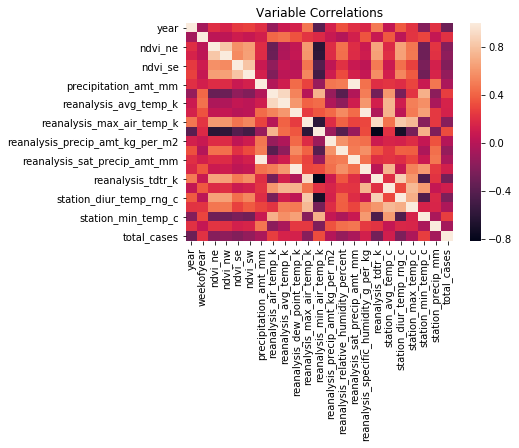

In [17]:
# plot san juan
corr_heat = sns.heatmap(correlations)
plt.title('Variable Correlations')

### Many of the temperature data are strongly correlated, which is expected. But the `total_cases` variable doesn't have many obvious strong correlations.

Interestingly, `total_cases` seems to only have weak correlations with other variables. Many of the climate variables are much more strongly correlated. Interestingly, the vegetation index also only has weak correlation with other variables. These correlations may give us some hints as to how to improve our model that we'll talk about later in this post. For now, let's take a `sorted` look at `total_cases` correlations.

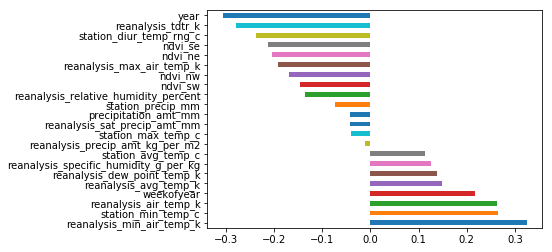

In [18]:
# ALL
(correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [19]:
num_val.drop('total_cases', axis=1, inplace=True)

## A mosquito model

Now that we've explored this data, it's time to start modeling. Our first step will be to build a function that does all of the preprocessing we've done above from start to finish. This will make our lives easier, since it needs to be applied to the test set and the traning set before we make our predictions.

Now we can take a look at the smaller dataset and see that it's ready to start modelling:

In [23]:
num_val.describe()


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,0.131271,0.128068,0.202606,0.201987,45.686937,298.697965,299.221483,295.245445,...,40.111635,82.176203,45.686937,16.745565,4.898656,27.180313,8.085646,32.443338,22.099863,39.194162
std,5.408314,15.019437,0.138527,0.119561,0.074409,0.083592,43.779318,1.361950,1.262676,1.527527,...,43.329174,7.161016,43.779318,1.542276,3.542340,1.280861,2.122836,1.960769,1.569113,47.363305
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.039100,0.048250,0.152795,0.144455,9.655000,297.654643,298.257143,294.119643,...,13.085000,77.185714,9.655000,15.560000,2.328571,26.300000,6.528571,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.113900,0.115926,0.195664,0.190121,38.235000,298.646429,299.285714,295.639286,...,27.245000,80.301429,38.235000,17.087143,2.857143,27.400000,7.364286,32.800000,22.200000,23.800000
75%,2005.000000,39.250000,0.232018,0.213429,0.247461,0.246775,70.227500,299.827500,300.207143,296.460000,...,52.200000,86.406429,70.227500,17.977500,7.617857,28.132143,9.600000,33.900000,23.300000,53.675000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


# Here we select the relavent variables to be used to make the model



In [24]:
#attributes = ["ndvi_se","year","weekofyear","station_min_temp_c","reanalysis_dew_point_temp_k","reanalysis_specific_humidity_g_per_kg","station_avg_temp_c"]
attributes = ["weekofyear","ndvi_se","station_min_temp_c","reanalysis_dew_point_temp_k","reanalysis_specific_humidity_g_per_kg","station_avg_temp_c"]






In [25]:
num_attribs= list(num_val[attributes])
cat_attribs=list(cat_val)
#print(num_attribs)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import labelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator,TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


In [27]:
num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_attribs)),
                         ('std_scaler', StandardScaler()),
                        ])

cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)), 
                         ('cat_encoder', OneHotEncoder()),
                        ])


# encode categorical data

In [28]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
enc.fit(cat_val)
new_cat_val = enc.transform(cat_val)
new_cat_val=new_cat_val.reshape(-1, 1)
ohe = preprocessing.OneHotEncoder(sparse=False)
cat_val1= ohe.fit_transform(new_cat_val)

num_values=(num_val[attributes])



# standardize the numerical values

In [29]:
#qq=StandardScaler(num_values)
num_values1=StandardScaler().fit_transform(num_values)
len(num_values1)

1456

In [31]:
#full_dataset = pd.concat((num_values, onehotlabels), axis=1)

full_dataset = pd.concat([pd.DataFrame(num_values1), pd.DataFrame(cat_val1)], axis=1)
full_dataset.tail()

,0,1,2,3,4,5,0,1
1451,-0.366547,0.722427,0.191344,1.034883,1.128687,1.134800,1.0,0.0
1452,-0.299943,-0.894858,-0.254921,0.790707,0.859048,0.197608,1.0,0.0
1453,-0.233340,0.641955,-1.848725,0.167638,0.170590,-2.171406,1.0,0.0
1454,-0.166737,1.025487,-0.701186,0.051631,0.045500,-1.364379,1.0,0.0
1455,-0.100134,0.962686,0.063840,0.367843,0.395752,0.230149,1.0,0.0


## Split it up!

Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(full_dataset,train_labels.total_cases, test_size=0.2)
#len(train_labels.total_cases)

In [33]:
X_train.head()


,0,1,2,3,4,5,0,1
503,1.698155,-0.462546,-0.637434,-0.889522,-0.965413,-1.334627,0.0,1.0
132,1.298535,-1.521242,0.446353,-0.112089,-0.171323,0.283145,0.0,1.0
642,0.632502,-0.508702,0.446353,0.889874,0.877580,0.249674,0.0,1.0
526,-0.233340,-0.455439,0.765113,0.276160,0.187268,0.528600,0.0,1.0
66,0.366089,-0.134710,1.466387,0.800998,0.746004,1.030667,0.0,1.0


## Training time

This is where we start getting down to business. 

In [34]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([10,50,200,250,500]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error',cv=kfold )
grid_result = grid.fit(rescaledX, y_train)


means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-1145.266777 (842.413082) with: {'n_estimators': 10}
-799.668980 (448.993929) with: {'n_estimators': 50}
-836.069059 (403.278767) with: {'n_estimators': 200}
-842.603689 (401.201042) with: {'n_estimators': 250}
-888.376038 (401.723033) with: {'n_estimators': 500}
Best: -799.668980 using {'n_estimators': 50}


In [35]:
from sklearn.metrics import mean_absolute_error 
model1= GradientBoostingRegressor(n_estimators=50, random_state=21)
m= model1.fit(rescaledX, y_train)
rescaledXt = scaler.transform(X_test)
predicted=m.predict(rescaledXt).astype(int)

mae=mean_absolute_error(y_test,predicted)
print(mae)

15.267123287671232


In [37]:
X_all=pd.concat([X_train, X_test])
rescaledXall = scaler.transform(X_all)
predictedall=m.predict(rescaledXall).astype(int)
#len(rescaledXall)
#print(predictedall)
#len(predictedall)
#len(train_labels.total_cases)

## Reflecting on our performance

These graphs can actually tell us a lot about where our model is going wrong and give us some good hints about where investments will improve the model performance. For example, we see that our model in blue does track the seasonality of Dengue cases. However, the timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past--that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is misquito born, and the misquito lifecycle depends on water, we need to take both the life of a misquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.

The other important error is that our predictions are relatively consistent--we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.

So, we know we're not going to win this thing, but let's submit the model anyway!

In [124]:
#sj_predictions = forest_reg.predict(sj_test).astype(int)

In [40]:
test_features = pd.read_csv('/Users/eroolpal/Downloads/dengue_features_test.csv')
cat_val = test_features.select_dtypes(include=['object']).copy()
cat_val.drop('week_start_date', axis=1, inplace=True)
num_val = test_features.drop(cat_val,axis=1)
num_val.fillna(method='ffill', inplace=True)
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
enc.fit(cat_val)
new_cat_val = enc.transform(cat_val)
new_cat_val=new_cat_val.reshape(-1, 1)
ohe = preprocessing.OneHotEncoder(sparse=False)
cat_val1= ohe.fit_transform(new_cat_val)
num_values=(num_val[attributes])
num_values1=StandardScaler().fit_transform(num_values)
X_t = pd.concat([pd.DataFrame(num_values1), pd.DataFrame(cat_val1)], axis=1)

rescaledXt = scaler.transform(X_t)
#len(cat_val)
predictions=m.predict(rescaledXt).astype(int)




submission = pd.read_csv("/Users/eroolpal/Downloads/submission_format.csv")

submission.total_cases = predictions
submission.to_csv("/Users/eroolpal/Downloads/benchmark_3.csv",index=False)


![](https://community.drivendata.org/uploads/default/original/1X/7af03e4997e8487057a77f9022691b9e9cb525f7.png)

Alright, it's a start! To build your own model you can grab this notebook [from our benchmarks repo](https://github.com/drivendata/benchmarks).

Good luck, and enjoy!